In [46]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import h5py
import matplotlib.pyplot as plt

In [113]:
def merge_chromosomes(h5):
    
    n_cells = h5['cell_barcodes'].value.shape[0]
    all_chromosomes = list(h5['cnvs'].keys())
    # list of all cnv arrays
    cnv_matrices = []
    for chr in all_chromosomes:
        cnv_matrices.append(h5['cnvs'][chr].value[0:n_cells,:]) # select only the cells, not cell groups
        
    cell_all_chrs = np.concatenate(cnv_matrices, axis=1)
    return cell_all_chrs

def filter_negative_bins(mat):
    df_arr = pd.DataFrame(mat)
    df_arr[df_arr < 0] = None
    column_filter_mask = ~df_arr.isnull().any()
    return column_filter_mask

def filter_multiple_negative_bins(mat0, mat1):
    
    # TODO: later re-use parts   
    df_arr0 = pd.DataFrame(mat0)
    df_arr0[df_arr0 < 0] = None
    column_filter_mask0 = ~df_arr0.isnull().any()
    
    df_arr1 = pd.DataFrame(mat1)
    df_arr1[df_arr1 < 0] = None
    column_filter_mask1 = ~df_arr1.isnull().any()
    
    
    return column_filter_mask0 & column_filter_mask1 


def cnv_plot_one_dataset(mat, chr_pos=[], chr_texts=[]):
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(311)
    ax.plot(mat,'r--')
    ax.axis([None, None, 0, 8])
    for i,pos in enumerate(chr_pos):
        ax.annotate(chr_texts[i], xy=(pos, 0),rotation=90, rotation_mode="anchor")
        ax.axvline(x=pos, ymin=0, ymax=1, ls='dashed', color='black', lw='0.2')
    ax.get_xaxis().set_visible(False)
    ax.legend(loc='upper left')
    plt.show()
    
def find_max_peak(sp, lb, ub, threshold):
    assert(lb < len(sp))
    assert(ub < len(sp))
    signal = np.copy(sp[lb:ub])
    signal_median = np.median(signal)
    signal /= np.median(signal)
    #print(signal_median)
    peaks = np.diff(np.sign(np.diff(signal,axis=0)),axis=0)
    mask = np.concatenate([[False],peaks==-2,[False]])
    if(sum(mask) > 0):
        max_val = signal[mask].max()
        if max_val > threshold:
            item_index = signal.tolist().index(max_val)
            # lb is the offset
            return item_index+lb
    return -1
    
def detect_all_peaks(sp, threshold):
    lb = 0
    ub = len(sp)-1
    wait_list = deque()
    wait_list.append((lb,ub))
    all_max_ids = []
    while (len(wait_list) != 0):
        elem = wait_list.popleft()
        if (elem[1] - elem[0]) > 5:
            max_idx = find_max_peak(sp, elem[0],elem[1], threshold)
            if max_idx != -1:
                all_max_ids.append(max_idx)
                wait_list.append((elem[0],max_idx))
                wait_list.append((max_idx, elem[1]))
    if all_max_ids:
        return sorted(all_max_ids)
    else:
        return []
    
def filter_peaks_nearby(sorted_ids,signal , window_size):    
    filtered_peaks = set()
    i = 0
    while (i < len(sorted_ids)):
        if((i != len(sorted_ids)-1) and abs(sorted_ids[i] - sorted_ids[i+1]) < 2*window_size):
            if(signal[sorted_ids[i]] > signal[sorted_ids[i+1]]):
                filtered_peaks.add(sorted_ids[i])
                i += 1
            else:
                filtered_peaks.add(sorted_ids[i+1])
                i += 1
        else:
            filtered_peaks.add(sorted_ids[i])
        i += 1
    return filtered_peaks
    
    
def plot_1d_signal(mat,  min_val, max_val, chr_pos=None, chr_texts=None): # Todo: have chr pos and chr text visualised
    plt.figure(figsize=(40,30))
    plt.subplots_adjust(left=None, bottom=-0.3, right=None, top=None, wspace=None, hspace=None)
    ax = plt.subplot(311)
    ax.plot(mat,'b--')
    ax.axis([None, None, min_val, max_val])
#     if chr_pos is not None:
#         for i,pos in enumerate(chr_pos):
#             ax.annotate(chr_texts[i], xy=(pos, 0.8),rotation=0, rotation_mode="anchor", clip_on=True)
#             ax.axvline(x=pos, ymin=0, ymax=1, color='red', lw='5.5', ls='dotted')
#     ax.get_xaxis().set_visible(False)
    ax.vlines(chr_pos,  *ax.get_xlim(), colors='g', linestyles='dashed', lw=1)
    #ax.legend(loc='upper left')
    return plt
    
def exclude_bins(bins_to_exclude, mat):
    exclude_bins_mask = [i in bins_to_exclude for i in range(0,mat.shape[1])]
    include_bins_mask = [not x for x in exclude_bins_mask]
    return mat[:,include_bins_mask]

In [3]:
# sp values
sp_vals = np.loadtxt('./sp_10x_chr1/20ws140732672314616regions_10nodes_10xchr1_sp.txt')

In [4]:
# reshape to make 2D with 1 column
sp_vals = np.reshape(sp_vals, (1, -1))

In [5]:
# detected region sizes
bps = [27,2,6,50,51,50,7,8,443,18,24,3,120,4,20,353,15,5,52,37,6,3,10,36,3,3,114,4,8,4,174,1439,178,329,312,241,19,357,8,618,7,8,13,6,4,207,11,15,10,32,3,69,120,11,311,8,14,6,18,1051,19,20,13,27,37,15,4,4,11,16,24,7,122,12,9,20,2,6,11,33,93,430,9,13,4,372,254,3,5,454,899,223,8,9,15,67,7,585,7,8,170,4,4,5,20,3,5,3,3,436,14,76,20,5,3,379,2,14,3,96,17,7,71,2,51,12,11,4,20,41]
# breakpoint positions
bp_pos = np.cumsum(bps)
bp_pos

array([   27,    29,    35,    85,   136,   186,   193,   201,   644,
         662,   686,   689,   809,   813,   833,  1186,  1201,  1206,
        1258,  1295,  1301,  1304,  1314,  1350,  1353,  1356,  1470,
        1474,  1482,  1486,  1660,  3099,  3277,  3606,  3918,  4159,
        4178,  4535,  4543,  5161,  5168,  5176,  5189,  5195,  5199,
        5406,  5417,  5432,  5442,  5474,  5477,  5546,  5666,  5677,
        5988,  5996,  6010,  6016,  6034,  7085,  7104,  7124,  7137,
        7164,  7201,  7216,  7220,  7224,  7235,  7251,  7275,  7282,
        7404,  7416,  7425,  7445,  7447,  7453,  7464,  7497,  7590,
        8020,  8029,  8042,  8046,  8418,  8672,  8675,  8680,  9134,
       10033, 10256, 10264, 10273, 10288, 10355, 10362, 10947, 10954,
       10962, 11132, 11136, 11140, 11145, 11165, 11168, 11173, 11176,
       11179, 11615, 11629, 11705, 11725, 11730, 11733, 12112, 12114,
       12128, 12131, 12227, 12244, 12251, 12322, 12324, 12375, 12387,
       12398, 12402,

In [6]:
bins_to_exclude = pd.read_csv('../data/10X_sc_cnv/bins_to_exclude01nov.txt', header=None)
bins_to_exclude = list(bins_to_exclude[0].values)

In [7]:
filename = '../data/10X_sc_cnv/bj_mkn45_10pct_cnv_data.h5'
f = h5py.File(filename, 'r')

In [8]:
n_cells = f['cell_barcodes'].value.shape[0]
n_cells

462

In [9]:
list(f.keys())

['cell_barcodes',
 'cnvs',
 'constants',
 'genome_tracks',
 'normalized_counts',
 'raw_counts',
 'tree']

In [10]:
cnvs_chr1 = f['cnvs']['1'].value[0:n_cells,:]

In [11]:
(cnvs_chr1.min(),cnvs_chr1.max())

(-128, 17)

In [12]:
cnvs_chr1.shape

(462, 12463)

In [13]:
negative_chr1 = filter_negative_bins(cnvs_chr1)

In [14]:
negative_chr1.shape

(12463,)

In [15]:
cnvs_chr1 = cnvs_chr1[:,negative_chr1]
cnvs_chr1 = exclude_bins(bins_to_exclude,cnvs_chr1)
cnvs_chr1.shape

(462, 10571)

In [16]:
(cnvs_chr1.min(),cnvs_chr1.max())

(0, 8)

In [17]:
raw_cnts_chr1 = f['raw_counts']['1'].value[0:n_cells,:]
raw_cnts_chr1 = exclude_bins(bins_to_exclude,raw_cnts_chr1)
raw_cnts_chr1.shape

(462, 12421)

In [18]:
(raw_cnts_chr1.min(),raw_cnts_chr1.max())

(0.0, 83.0)

In [19]:
norm_cnts_chr1 = f['normalized_counts']['1'].value[0:n_cells,:]
norm_cnts_chr1 = exclude_bins(bins_to_exclude,norm_cnts_chr1)
norm_cnts_chr1.shape

(462, 12421)

In [20]:
(norm_cnts_chr1.min(),norm_cnts_chr1.max())

(0.0, 83.0)

In [21]:
f.close()

## Norm counts histograms

### Hierarchical clustering

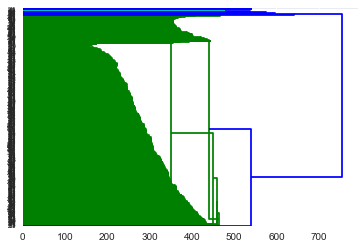

In [22]:
import scipy
import scipy.cluster.hierarchy as sch

# Generate features and distance matrix.
D = norm_cnts_chr1
# Compute and plot dendrogram.
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
index = Z['leaves']
D = D[index,:]

Number of breakpoints detected.

In [23]:
len(bp_pos)

130

In [38]:
D.shape

(462, 12421)

In [73]:
mean_counts = D.mean(axis=0)

In [55]:
# reshape to make 2D with 1 column
mean_counts = np.reshape(mean_counts, (1, -1))

In [98]:
mean_counts

array([0.7060029 , 0.05350008, 1.2198564 , ..., 5.6814017 , 2.1810482 ,
       0.26258639], dtype=float32)

In [99]:
bp_pos.flatten().shape

(130,)

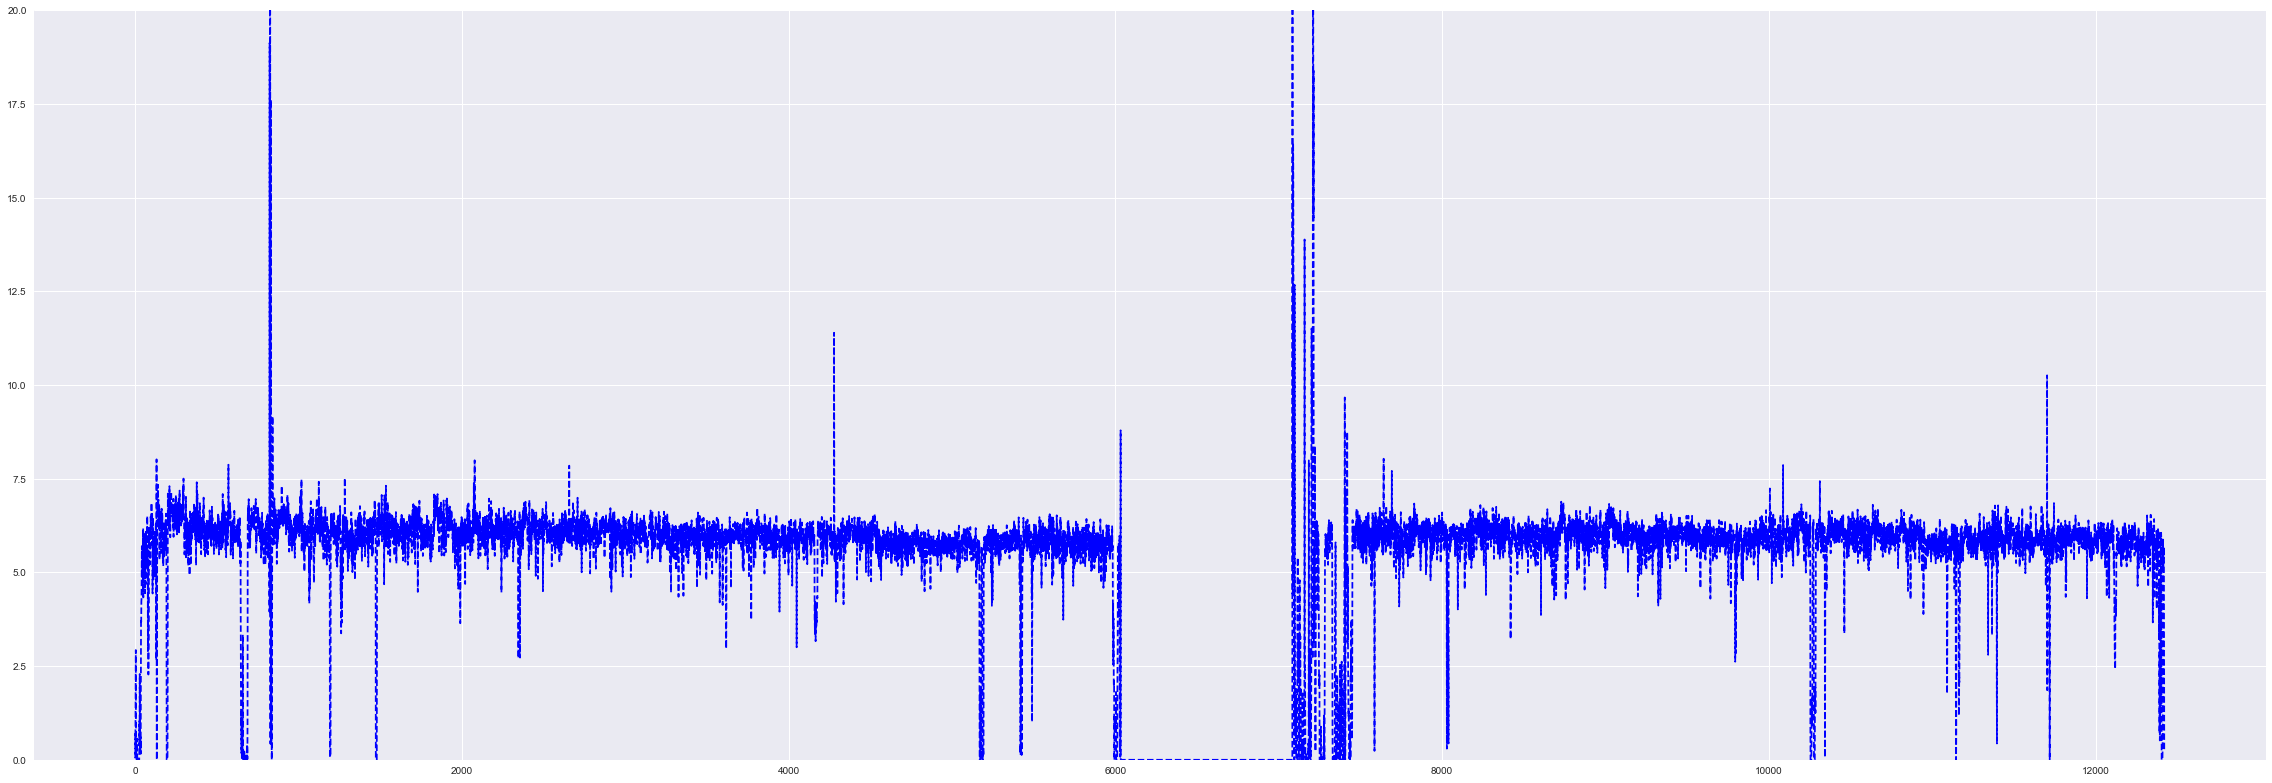

In [115]:
plt = plot_1d_signal(mean_counts, 0, 20)
#plt.show()
plt.savefig('mean_counts.png')

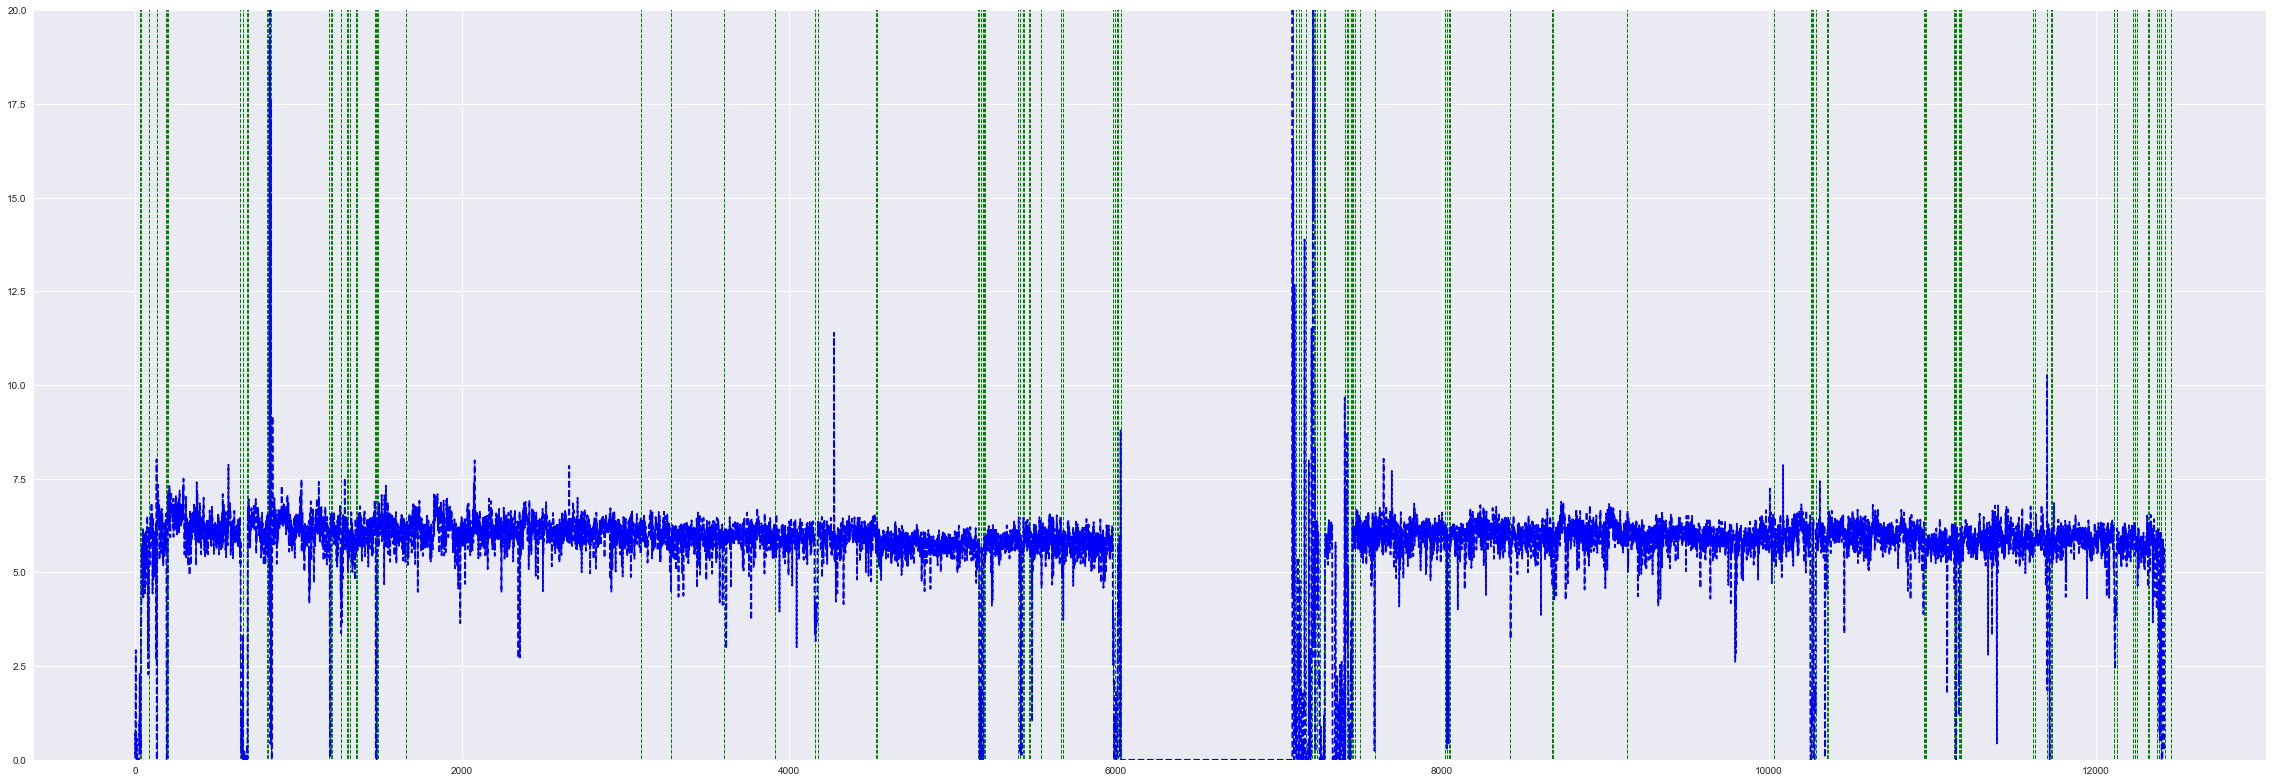

In [116]:
plt = plot_1d_signal(mean_counts, 0, 20,chr_pos=bp_pos)
plt.savefig('mean_counts_annotated.png')

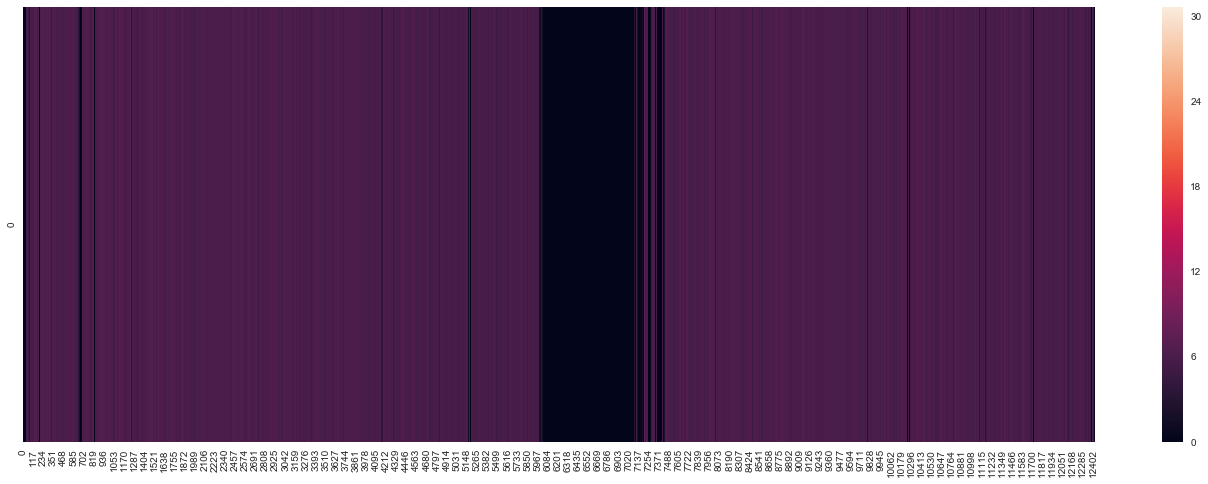

In [58]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(mean_counts)

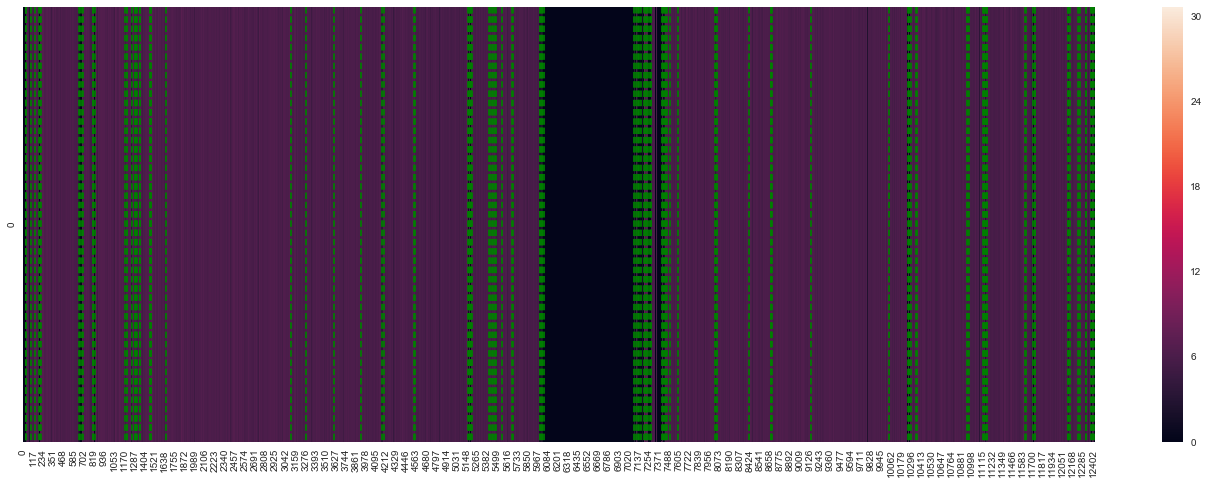

In [57]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(mean_counts)
ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

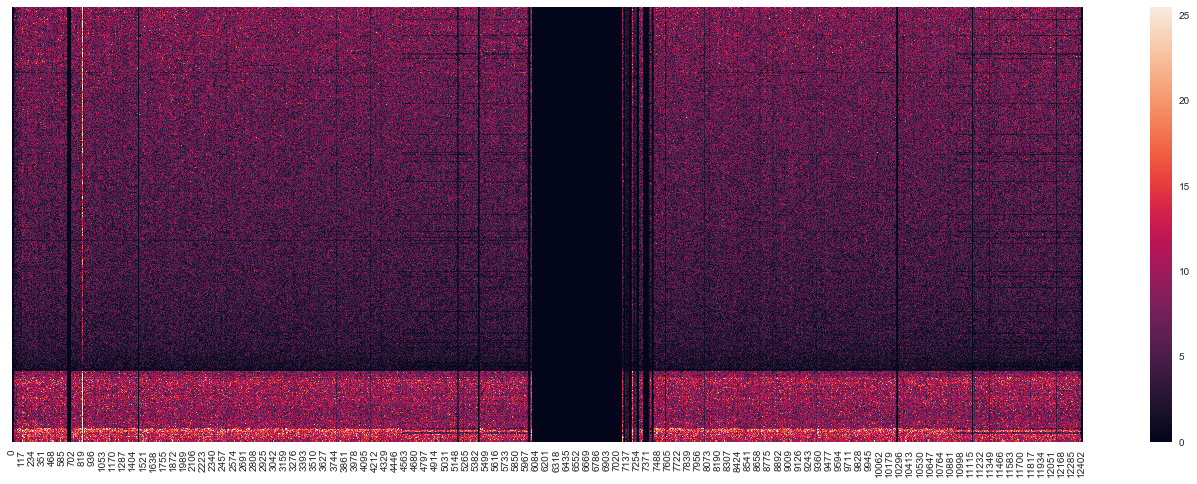

In [24]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(D,vmax=25.5, yticklabels=False)

[{"varName": "D", "varType": "ndarray", "varSize": "22954008", "varContent": "[[ 1.0789393  0.         0.960681  ...  5.005653   1.968197   0.       ]\n [ 0.         0.9814419  2.1105921 ...  8.989919   1.018172   0.       ]\n [ 0.         0.         1.9408453 ...  9.011111   2.9"}, {"varName": "Y", "varType": "ndarray", "varSize": "14752", "varContent": "[[217.         357.         173.99029786   2.        ]\n [177.         462.         159.90712161   3.        ]\n [  0.         463.         163.34265586   4.        ]\n ...\n [ 82.         919.         59"}, {"varName": "Z", "varType": "dict", "varSize": "240", "varContent": "{'icoord': [[3855.0, 3855.0, 3865.0, 3865.0], [3845.0, 3845.0, 3860.0, 3860.0], [3835.0, 3835.0, 3852.5, 3852.5], [3825.0, 3825.0, 3843.75, 3843.75], [3815.0, 3815.0, 3834.375, 3834.375], [3805.0, 380"}, {"varName": "ax", "varType": "AxesSubplot", "varSize": "56", "varContent": "AxesSubplot(0.125,0.125;0.62x0.755)"}, {"varName": "bins_to_exclude", "varType": "lis

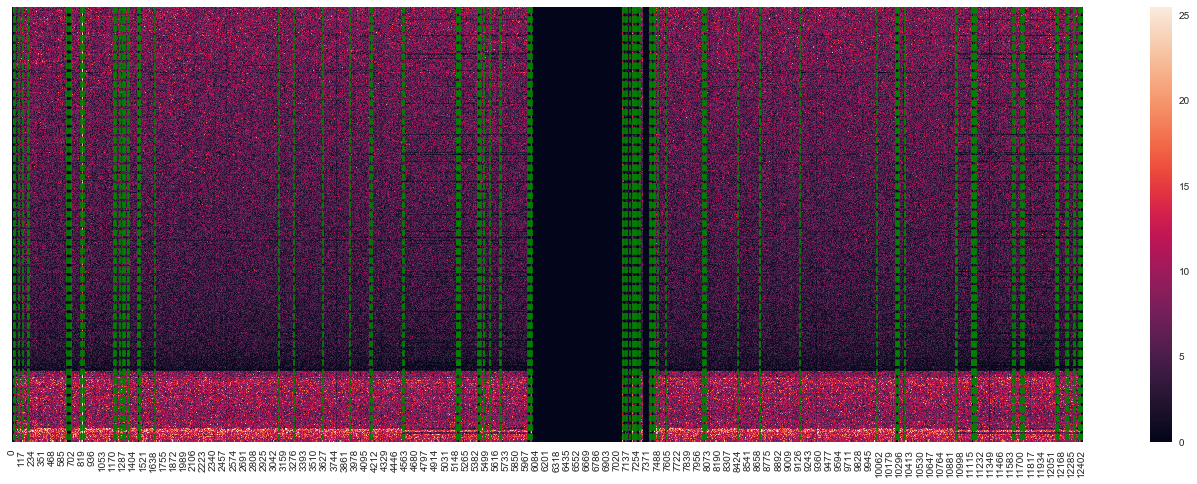

In [25]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(D,vmax=25.5, yticklabels=False)
ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

In [26]:
aic_df = pd.read_csv('sp_10x_chr1/aic_scores_with_bp_no.txt')

In [27]:
aic_df.head()

aic_segment   aic_break   aic_slope       aic_p  bp_no
0    51.752871  186.575894   53.280468 -134.823023     20
1   110.079672  249.730043  189.565154 -139.650371     20
2    93.011944  508.178652  134.687608 -415.166709     20
3    99.664731  579.308981  107.419925 -479.644250     20
4   107.338061  669.508496  111.640103 -562.170435     20

In [28]:
aic_df.shape

(5739426, 5)

In [29]:
# group by bp 
grouped_aic_df = aic_df.groupby(['bp_no']).mean()

In [30]:
grouped_aic_df.shape

(12423, 4)

In [31]:
grouped_aic_df[['aic_segment', 'aic_break', 'aic_slope']].values

array([[ 99.79107338, 510.13997737, 127.53741577],
       [105.83546373, 463.0290543 , 154.27512054],
       [113.45692432, 407.66020788, 186.04680618],
       ...,
       [  4.40948785,   8.84507195,   5.89933015],
       [  2.        ,   4.008     ,   4.008     ],
       [  2.        ,   4.008     ,   4.008     ]])

## AIC Delta Values

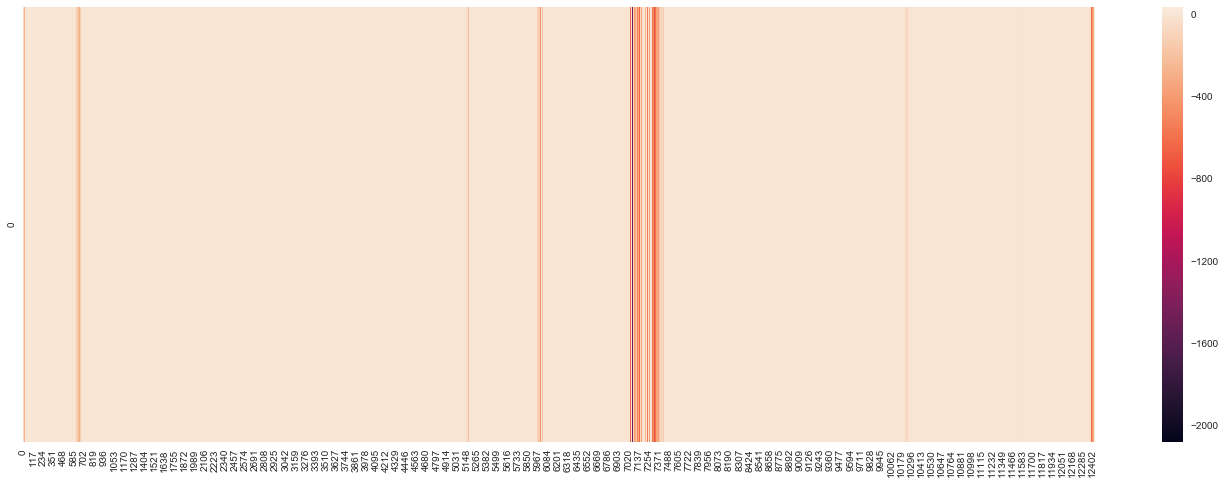

In [32]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(grouped_aic_df[['aic_p']].T.values)
#ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

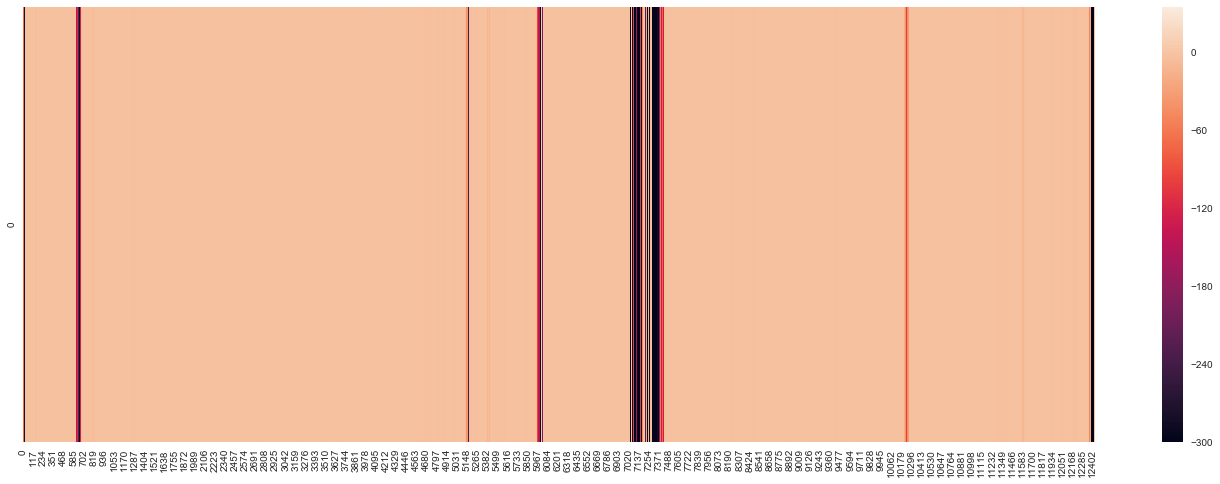

In [33]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(grouped_aic_df[['aic_p']].T.values, vmin=-300)
#ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

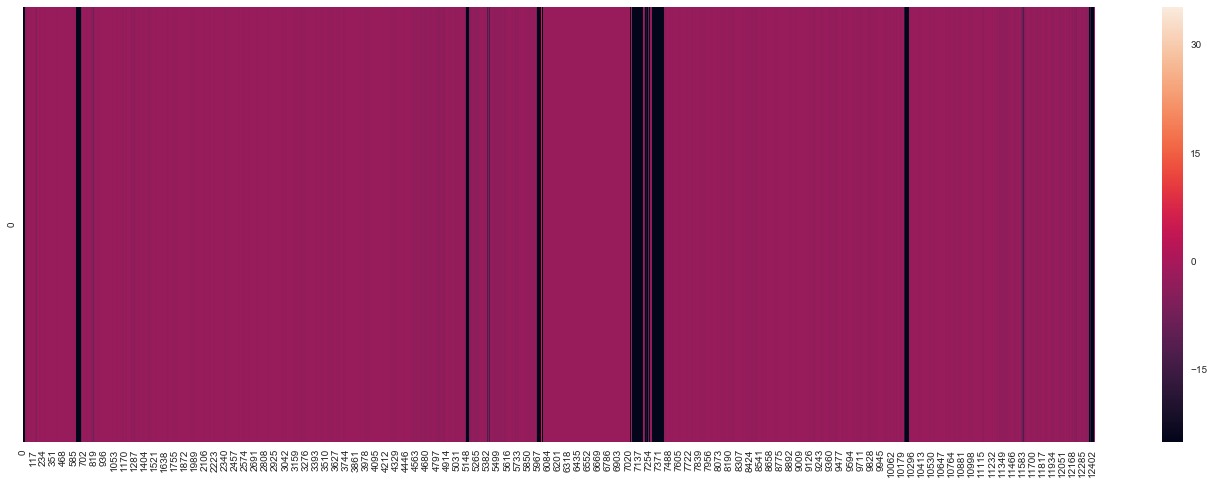

In [34]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(grouped_aic_df[['aic_p']].T.values, vmin=-25)
#ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

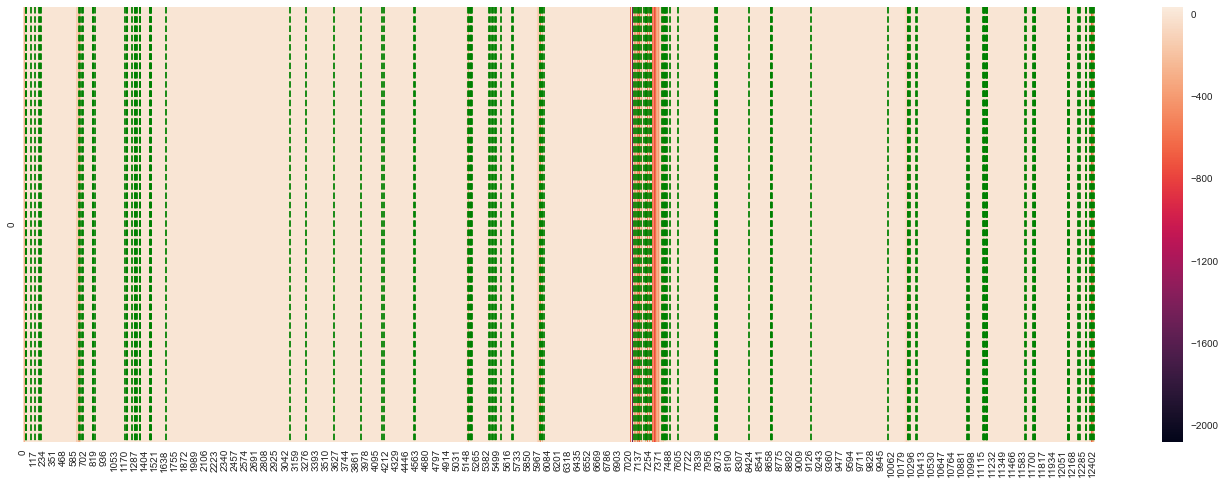

In [35]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(grouped_aic_df[['aic_p']].T.values)
ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

## SP values

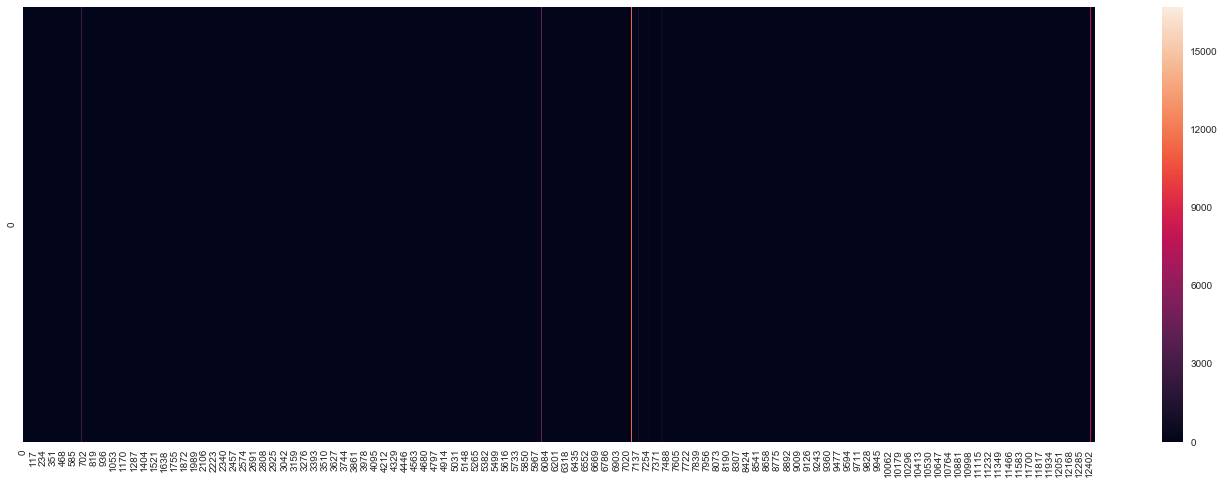

In [36]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(sp_vals)
#ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')

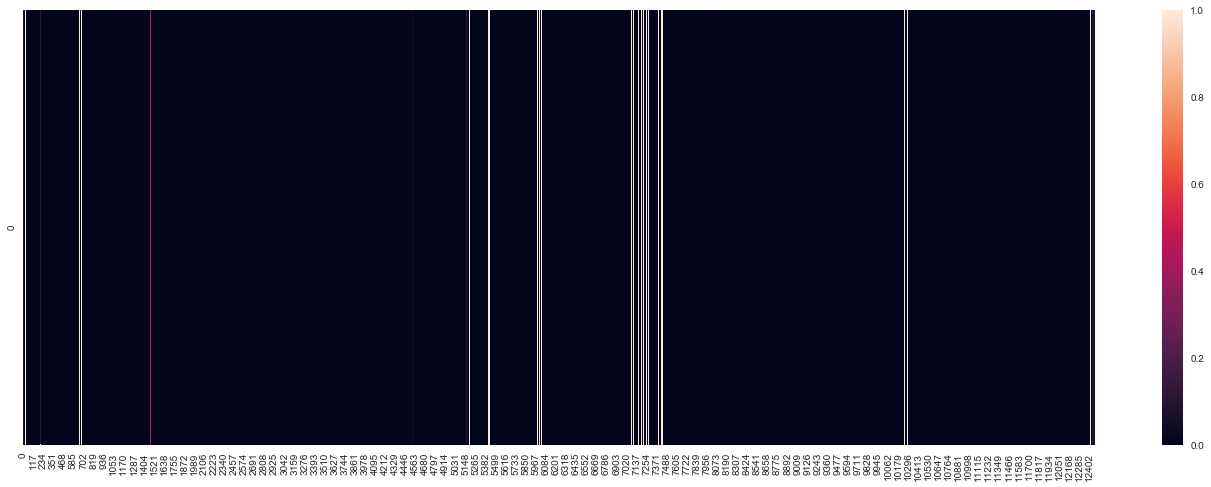

In [37]:
plt.figure(figsize = (24,8))
ax = sns.heatmap(sp_vals, vmax=1)
#ax.vlines(bp_pos,  *ax.get_xlim(), colors='g', linestyles='dashed')